In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.chdir('../')

In [43]:
from utils.config import Config
config_file = "configs/config.json"
cfg = Config.from_file(config_file)

In [44]:
import os
import io

from models.videochat2_it import VideoChat2_it
from utils.easydict import EasyDict
import torch

from transformers import StoppingCriteria, StoppingCriteriaList

from PIL import Image
import numpy as np
import numpy as np
from decord import VideoReader, cpu
import torchvision.transforms as T
from dataset.video_transforms import (
    GroupNormalize, GroupScale, GroupCenterCrop, 
    Stack, ToTorchFormatTensor
)
from torchvision.transforms.functional import InterpolationMode

from torchvision import transforms

import matplotlib.pyplot as plt

from IPython.display import Video, HTML

from peft import get_peft_model, LoraConfig, TaskType
import copy

In [45]:
# load stage2 model
cfg.model.vision_encoder.num_frames = 4
model = VideoChat2_it(config=cfg.model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [59]:
# add lora to run stage3 model
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False, 
    r=16, lora_alpha=32, lora_dropout=0.
)
model.llama_model = get_peft_model(model.llama_model, peft_config)

state_dict = torch.load("your_model_path/videochat2_7b_stage3.pth", "cpu")

if 'model' in state_dict.keys():
    msg = model.load_state_dict(state_dict['model'], strict=False)
else:
    msg = model.load_state_dict(state_dict, strict=False)
print(msg)

model = model.eval()

_IncompatibleKeys(missing_keys=['llama_model.base_model.model.model.embed_tokens.weight', 'llama_model.base_model.model.model.layers.0.self_attn.q_proj.weight', 'llama_model.base_model.model.model.layers.0.self_attn.k_proj.weight', 'llama_model.base_model.model.model.layers.0.self_attn.v_proj.weight', 'llama_model.base_model.model.model.layers.0.self_attn.o_proj.weight', 'llama_model.base_model.model.model.layers.0.mlp.gate_proj.weight', 'llama_model.base_model.model.model.layers.0.mlp.down_proj.weight', 'llama_model.base_model.model.model.layers.0.mlp.up_proj.weight', 'llama_model.base_model.model.model.layers.0.input_layernorm.weight', 'llama_model.base_model.model.model.layers.0.post_attention_layernorm.weight', 'llama_model.base_model.model.model.layers.1.self_attn.q_proj.weight', 'llama_model.base_model.model.model.layers.1.self_attn.k_proj.weight', 'llama_model.base_model.model.model.layers.1.self_attn.v_proj.weight', 'llama_model.base_model.model.model.layers.1.self_attn.o_proj.

In [49]:
def get_prompt(conv):
    ret = conv.system + conv.sep
    for role, message in conv.messages:
        if message:
            ret += role + ": " + message + conv.sep
        else:
            ret += role + ":"
    return ret


def get_prompt2(conv):
    ret = conv.system + conv.sep
    count = 0
    for role, message in conv.messages:
        count += 1
        if count == len(conv.messages):
            ret += role + ": " + message
        else:
            if message:
                ret += role + ": " + message + conv.sep
            else:
                ret += role + ":"
    return ret


def get_context_emb(conv, model, img_list, answer_prompt=None, print_res=False):
    if answer_prompt:
        prompt = get_prompt2(conv)
    else:
        prompt = get_prompt(conv)
    if print_res:
        print(prompt)
    if '<VideoHere>' in prompt:
        prompt_segs = prompt.split('<VideoHere>')
    else:
        prompt_segs = prompt.split('<ImageHere>')
    assert len(prompt_segs) == len(img_list) + 1, "Unmatched numbers of image placeholders and images."
    with torch.no_grad():
        seg_tokens = [
            model.llama_tokenizer(
                seg, return_tensors="pt", add_special_tokens=i == 0).to("cuda:0").input_ids
            # only add bos to the first seg
            for i, seg in enumerate(prompt_segs)
        ]
        seg_embs = [model.llama_model.base_model.model.model.embed_tokens(seg_t) for seg_t in seg_tokens]
    mixed_embs = [emb for pair in zip(seg_embs[:-1], img_list) for emb in pair] + [seg_embs[-1]]
    mixed_embs = torch.cat(mixed_embs, dim=1)
    return mixed_embs


def ask(text, conv):
    conv.messages.append([conv.roles[0], text + '\n'])
        

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops=[], encounters=1):
        super().__init__()
        self.stops = stops
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        for stop in self.stops:
            if torch.all((stop == input_ids[0][-len(stop):])).item():
                return True
        return False
    
    
def answer(conv, model, img_list, do_sample=True, max_new_tokens=200, num_beams=1, min_length=1, top_p=0.9,
               repetition_penalty=1.0, length_penalty=1, temperature=1.0, answer_prompt=None, print_res=False):
    stop_words_ids = [
        torch.tensor([835]).to("cuda:0"),
        torch.tensor([2277, 29937]).to("cuda:0")]  # '###' can be encoded in two different ways.
    stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])
    
    conv.messages.append([conv.roles[1], answer_prompt])
    embs = get_context_emb(conv, model, img_list, answer_prompt=answer_prompt, print_res=print_res)
    with torch.no_grad():
        outputs = model.llama_model.generate(
            inputs_embeds=embs,
            max_new_tokens=max_new_tokens,
            stopping_criteria=stopping_criteria,
            num_beams=num_beams,
            do_sample=do_sample,
            min_length=min_length,
            top_p=top_p,
            repetition_penalty=repetition_penalty,
            length_penalty=length_penalty,
            temperature=temperature,
        )
    output_token = outputs[0]
    if output_token[0] == 0:  # the model might output a unknow token <unk> at the beginning. remove it
            output_token = output_token[1:]
    if output_token[0] == 1:  # some users find that there is a start token <s> at the beginning. remove it
            output_token = output_token[1:]
    output_text = model.llama_tokenizer.decode(output_token, add_special_tokens=False)
    output_text = output_text.split('###')[0]  # remove the stop sign '###'
    output_text = output_text.split('Assistant:')[-1].strip()
    conv.messages[-1][1] = output_text
    return output_text, output_token.cpu().numpy()

In [51]:
def get_index(num_frames, num_segments):
    seg_size = float(num_frames - 1) / num_segments
    start = int(seg_size / 2)
    offsets = np.array([
        start + int(np.round(seg_size * idx)) for idx in range(num_segments)
    ])
    return offsets


def load_video(video_path, num_segments=8, return_msg=False, resolution=224):
    vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
    num_frames = len(vr)
    frame_indices = get_index(num_frames, num_segments)

    # transform
    crop_size = resolution
    scale_size = resolution
    input_mean = [0.48145466, 0.4578275, 0.40821073]
    input_std = [0.26862954, 0.26130258, 0.27577711]

    transform = T.Compose([
        GroupScale(int(scale_size), interpolation=InterpolationMode.BICUBIC),
        GroupCenterCrop(crop_size),
        Stack(),
        ToTorchFormatTensor(),
        GroupNormalize(input_mean, input_std) 
    ])

    images_group = list()
    for frame_index in frame_indices:
        img = Image.fromarray(vr[frame_index].numpy())
        images_group.append(img)
    torch_imgs = transform(images_group)
    if return_msg:
        fps = float(vr.get_avg_fps())
        sec = ", ".join([str(round(f / fps, 1)) for f in frame_indices])
        # " " should be added in the start and end
        msg = f"The video contains {len(frame_indices)} frames sampled at {sec} seconds."
        return torch_imgs, msg
    else:
        return torch_imgs

In [52]:
def get_sinusoid_encoding_table(n_position=784, d_hid=1024, cur_frame=8, ckpt_num_frame=4, pre_n_position=784): 
    ''' Sinusoid position encoding table ''' 
    # TODO: make it with torch instead of numpy 
    def get_position_angle_vec(position): 
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)] 
    
    # generate checkpoint position embedding
    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(pre_n_position)]) 
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # dim 2i 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # dim 2i+1 
    sinusoid_table = torch.tensor(sinusoid_table, dtype=torch.float, requires_grad=False).unsqueeze(0)
    
    print(f"n_position: {n_position}")
    print(f"pre_n_position: {pre_n_position}")
    
    if n_position != pre_n_position:
        T = ckpt_num_frame # checkpoint frame
        P = 14 # checkpoint size
        C = d_hid
        new_P = int((n_position // cur_frame) ** 0.5) # testing size
        if new_P != 14:
            print(f'Pretraining uses 14x14, but current version is {new_P}x{new_P}')
            print(f'Interpolate the position embedding')
            sinusoid_table = sinusoid_table.reshape(-1, T, P, P, C)
            sinusoid_table = sinusoid_table.reshape(-1, P, P, C).permute(0, 3, 1, 2)
            sinusoid_table = torch.nn.functional.interpolate(
                sinusoid_table, size=(new_P, new_P), mode='bicubic', align_corners=False)
            # BT, C, H, W -> BT, H, W, C ->  B, T, H, W, C
            sinusoid_table = sinusoid_table.permute(0, 2, 3, 1).reshape(-1, T, new_P, new_P, C)
            sinusoid_table = sinusoid_table.flatten(1, 3)  # B, THW, C
    
    if cur_frame != ckpt_num_frame:
        print(f'Pretraining uses 4 frames, but current frame is {cur_frame}')
        print(f'Interpolate the position embedding')
        T = ckpt_num_frame # checkpoint frame
        new_T = cur_frame # testing frame
        # interpolate
        P = int((n_position // cur_frame) ** 0.5) # testing size
        C = d_hid
        sinusoid_table = sinusoid_table.reshape(-1, T, P, P, C)
        sinusoid_table = sinusoid_table.permute(0, 2, 3, 4, 1).reshape(-1, C, T)  # BHW, C, T
        sinusoid_table = torch.nn.functional.interpolate(sinusoid_table, size=new_T, mode='linear')
        sinusoid_table = sinusoid_table.reshape(1, P, P, C, new_T).permute(0, 4, 1, 2, 3) # B, T, H, W, C
        sinusoid_table = sinusoid_table.flatten(1, 3)  # B, THW, C
        
    return sinusoid_table

In [64]:
vid_path = "./example/yoga.mp4"
# vid_path = "./example/jesse_dance.mp4"


# num_frame = 8
num_frame = 16
# resolution = 384
resolution = 224
vid, msg = load_video(vid_path, num_segments=num_frame, return_msg=True, resolution=resolution)
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb

print(msg)
    
# The model expects inputs of shape: T x C x H x W
TC, H, W = vid.shape
video = vid.reshape(1, TC//3, 3, H, W).to("cuda:0")

img_list = []
with torch.no_grad():
    image_emb, _ = model.encode_img(video, "Watch the video and answer the question.")
#     image_emb, _ = model.encode_img(video, "")

img_list.append(image_emb)

HTML(f'<video alt="test" controls><source src="{vid_path}" type="video/mp4"></video>')

n_position: 3136
pre_n_position: 784
Pretraining uses 4 frames, but current frame is 16
Interpolate the position embedding
The video contains 16 frames sampled at 0.3, 0.9, 1.5, 2.2, 2.8, 3.4, 4.0, 4.7, 5.3, 5.9, 6.5, 7.2, 7.8, 8.4, 9.0, 9.6 seconds.


In [65]:
chat = EasyDict({
    "system": "",
    "roles": ("Human", "Assistant"),
    "messages": [],
    "sep": "###"
})

chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video>\n"])
ask("Describe the video in details.", chat)

llm_message = answer(conv=chat, model=model, do_sample=False, img_list=img_list, max_new_tokens=256, print_res=True)[0]
print(llm_message)

###Human: <Video><VideoHere></Video>
###Human: Describe the video in details.
###Assistant:
The video shows a woman performing yoga on a mat in a beautiful outdoor setting. She is wearing a black tank top and black leggings. The woman is seen performing various yoga poses, including a forward bend, a downward facing dog, and a bridge pose. The video also shows the woman stretching and doing some breathing exercises. The outdoor setting provides a peaceful and serene atmosphere for the yoga practice.


n_position: 196
pre_n_position: 196


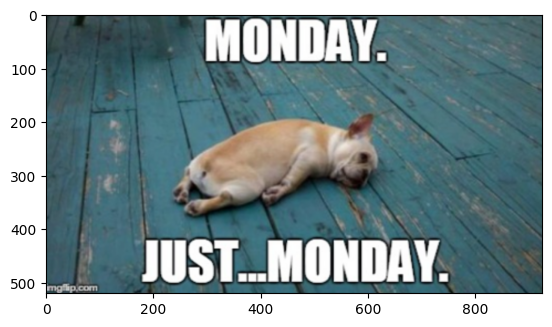

In [55]:
img_path = "./example/dog.png"
# img_path = "./example/bear.jpg"
img = Image.open(img_path).convert('RGB')

plt.imshow(img)

resolution = 224
# resolution = 384
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2, cur_frame=1, ckpt_num_frame=1, pre_n_position=14*14)
model.vision_encoder.encoder.img_pos_embed = new_pos_emb

transform = transforms.Compose(
    [
        transforms.Resize(
            (resolution, resolution), interpolation=InterpolationMode.BICUBIC
        ),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ]
)

img = transform(img).unsqueeze(0).unsqueeze(0).cuda()
img_list = []
with torch.no_grad():
#     image_emb, _ = model.encode_img(img, "")
    image_emb, _ = model.encode_img(img, "Observe the image and answer the question.")
img_list.append(image_emb)

In [56]:
chat = EasyDict({
    "system": "",
    "roles": ("Human", "Assistant"),
    "messages": [],
    "sep": "###"
})

chat.messages.append([chat.roles[0], f"<Image><ImageHere></Image>\n"])
ask("Describe the following image in details.", chat)

llm_message = answer(conv=chat, model=model, do_sample=False, img_list=img_list, max_new_tokens=256, print_res=True,)[0]
print(llm_message)

###Human: <Image><ImageHere></Image>
###Human: Describe the following image in details.
###Assistant:
The image depicts a cute little dog lying on a wooden floor. The dog is sleeping and appears to be enjoying its rest. The background of the image is a wooden floor, and the dog is lying on it. The dog is a small brown and white dog, and it is sleeping peacefully. The caption under the image reads "Just Monday. Just Monday. Just Monday." This suggests that the dog is taking a break from its daily routine and enjoying its rest.
